In [1]:
# import numpy as np 
# import pandas as pd

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

## Install required packages

In [2]:
import os

In [3]:
# !pip install numpy==1.17.0
# !pip install tensorflow==1.15.2
# !pip install keras==2.1.0

In [4]:
# !git clone https://www.github.com/matterport/Mask_RCNN.git

In [5]:
!ls

CrowAI Food Recognition.ipynb           mask_rcnn_crowai-food-challenge_0039.h5
Mask_RCNN                               mask_rcnn_crowai-food-challenge_0045.h5
mask_rcnn_crowai-food-challenge_0016.h5 test_images
mask_rcnn_crowai-food-challenge_0021.h5 test_images.tar.gz
mask_rcnn_crowai-food-challenge_0025.h5 train
mask_rcnn_crowai-food-challenge_0027.h5 train.tar.gz
mask_rcnn_crowai-food-challenge_0029.h5 val
mask_rcnn_crowai-food-challenge_0030.h5 val.tar.gz
mask_rcnn_crowai-food-challenge_0032.h5


In [6]:
# os.chdir("Food Recogtition/Mask RCNN/")

In [131]:
# !pip install -r requirements.txt

In [132]:
# !python setup.py -q install

In [133]:
# !pip uninstall pycocotools -y
# !pip install -q git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

## Import packages

In [134]:
ROOT_DIR = ""

In [135]:
# !pip install tqdm

In [148]:
import sys
sys.path.append(os.path.join(".", "Mask_RCNN"))
sys.path.append(ROOT_DIR)
import re
import random
import pandas as pd
import numpy as np
import mrcnn.model as modellib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib
import math
import logging
import json
import itertools
import glob
import cv2
from tqdm import tqdm
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn import utils
from collections import Counter, defaultdict
import imgaug as ia
from imgaug import augmenters as iaa

In [137]:
ROOT_DIR = os.path.abspath(".")
ROOT_DIR

'/Users/sun_admin/Documents/Git/Food Recogtition/Mask_RCNN'

## Constant variables

In [138]:
DATA_TRAIN_DIR = "../train/"
DATA_VAL_DIR = "../val/"

## Defining DatasetClass and Config

In [139]:
class FoodChallengeDataset(utils.Dataset):
    def load_dataset(self, dataset_dir, load_small=False, return_coco=True):
        self.load_small = load_small
        
        if self.load_small:
            self.annotation_path = os.path.join(dataset_dir, "annotations-small.json")
        else:
            self.annotation_path = os.path.join(dataset_dir, "annotations.json")
        
        image_dir = os.path.join(dataset_dir, "images")
        print("Annotation path", self.annotation_path)
        print("Image Dir", image_dir)
        
        assert os.path.exists(self.annotation_path) and os.path.exists(image_dir)
        
        self.coco = COCO(self.annotation_path)
        self.image_dir = image_dir
        
        class_ids = self.coco.getCatIds()
        image_ids = list(self.coco.imgs.keys())
        
        #Register classes
        for _class_id in class_ids:
            self.add_class("crowdai_food_challenge", _class_id, self.coco.loadCats(_class_id)[0]["name"])
            
        #Register images
        for _img_id in image_ids:
            assert os.path.exists(os.path.join(self.image_dir, self.coco.imgs[_img_id]["file_name"]))
            self.add_image(
                "crowdai_food_challenge", image_id=_img_id, 
                path=os.path.join(self.image_dir, self.coco.imgs[_img_id]["file_name"]),
                width=self.coco.imgs[_img_id]["width"],
                height=self.coco.imgs[_img_id]["height"],
                annotations=self.coco.loadAnns(self.coco.getAnnIds(
                                                                    imgIds=_img_id,
                                                                    catIds=class_ids,
                                                                    iscrowd=None
                                                                   )
                                              )
            )
        
        if return_coco:
            return self.coco
        
    def load_mask(self, image_id):
        image_infor = self.image_info[image_id]
        print(image_info["source"])
        assert image_info["source"] == "crowdai_food_challenge"
        
        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        
        for annotation in annotations:
            class_id = self.map_source_class_id("crowdai_food_challenge.{}".format(annotation["category_id"]))
            
            if class_id:
                m = self.annToMask(annotation, image_infor["height"], image_infor["width"])
                
                if m.max() < 1:
                    continue
                    
                instance_masks.append(m)
                class_ids.append(class_id)
        
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.uint32)
            return mask, class_ids
        else:
            return super(FoodChallengeDataset, self).load_mask(image_id)
        
    def image_reference(self, image_id):
        return "crowai-food-challenge::{}".format(image_id)
    
    def annToRLE(self, ann, height, width):
        segm = ann["segmentation"]
        
        if isinstance(segm, list):
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm["count"], list):
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            rle = ann['segmentation']
            
        return rle
    
    def annToMask(self, ann, height, width):
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [141]:
class FoodChallengeConfig(Config):
    NAME = "crowai-food-challenge"
#     BATCH_SIZE = 32
#     IMAGES_PER_GPU = 2
#     GPU_COUNT = 1
    BACKBONE = 'resnet50'
    NUM_CLASSES = 62 # n_classes + background
    STEPS_PER_EPOCH = len(dataset_train.image_ids) // 2
    VALIDATION_STEPS = len(dataset_val.image_ids) // 2
    LEARNING_RATE = 0.001
    IMAGE_MAX_DIM = 256
    IMAGE_MIN_DIM = 256

In [142]:
config = FoodChallengeConfig()

In [143]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                74
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [144]:
dataset_train = FoodChallengeDataset()

In [145]:
dataset_train.load_dataset(DATA_TRAIN_DIR, load_small=False, return_coco=True)

Annotation path ../train/annotations.json
Image Dir ../train/images
loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


In [146]:
dataset_train.prepare()
dataset = dataset_train

## Data Augmentation

In [149]:
def _load_aug_geometric():
    return iaa.OneOf([
        iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.2)]),
        iaa.CropAndPad(
            percent=(-0.05,0.1),
            pad_mode='constant',
            pad_cval=(0, 255)
        ),
        iaa.Crop(percent=(0.0, 0.1)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Sequential([
            iaa.Affine(
                scale={'x': (0.8, 1.2), 'y': (0.8, 1.2)},
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-45, 45),
                shear=(-16, 16),
                order=[0, 1],
                mode="constant",
                cval=(0, 255),
            ),
            iaa.Sometimes(0.3, iaa.Crop(percent=(0.3, 0.5)))
        ])
    ])

In [150]:
def _load_aug_non_geometric():
    return iaa.Sequential([
        iaa.Sometimes(0.3, iaa.Multiply((0.5, 1.5), per_channel=0.5)),
        iaa.Sometimes(0.2, iaa.JpegCompression(compression=(70, 99))),
        iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Sometimes(0.2, iaa.MotionBlur(k=15, angle=[-45, 45])),
        iaa.Sometimes(0.2, iaa.MultiplyHue((0.5, 1.5))),
        iaa.Sometimes(0.2, iaa.MultiplySaturation((0.5, 1.5))),
        iaa.Sometimes(0.34, iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True)),
        iaa.Sometimes(0.34, iaa.Grayscale(alpha=(0.0, 1.0))),
        iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.1, iaa.GammaContrast((0.5, 2.0))),
        iaa.Sometimes(0.2, iaa.SigmoidContrast(gain=(3, 10),
                                               cutoff=(0.4, 0.6))),
        iaa.Sometimes(0.1, iaa.CLAHE()),
        iaa.Sometimes(0.1, iaa.HistogramEqualization()),
        iaa.Sometimes(0.2, iaa.LinearContrast((0.5, 2.0), per_channel=0.5)),
        iaa.Sometimes(0.1, iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)))
    ])

In [155]:
def _load_augmentation_aug_all():
    return iaa.Sequential([
        iaa.Sometimes(0.65, _load_aug_geometric()),
        iaa.Sometimes(0.65, _load_aug_non_geometric()),
    ])

In [156]:
list_augment_support = {
    "aug_all": _load_augmentation_aug_all,
    "aug_geometric": _load_aug_geometric,
    "aug_non_geometric": _load_aug_non_geometric
}

In [157]:
def load_aug(aug_name="aug_all"):
    if DATA_AUGMENTATION_SEQUENCE is None:
        DATA_AUGMENTATION_SEQUENCE = list_augment_support[aug_name]()
        
    return DATA_AUGMENTATION_SEQUENCE

## Dataset Exploration

In [24]:
from collections import Counter

class_counts = Counter()

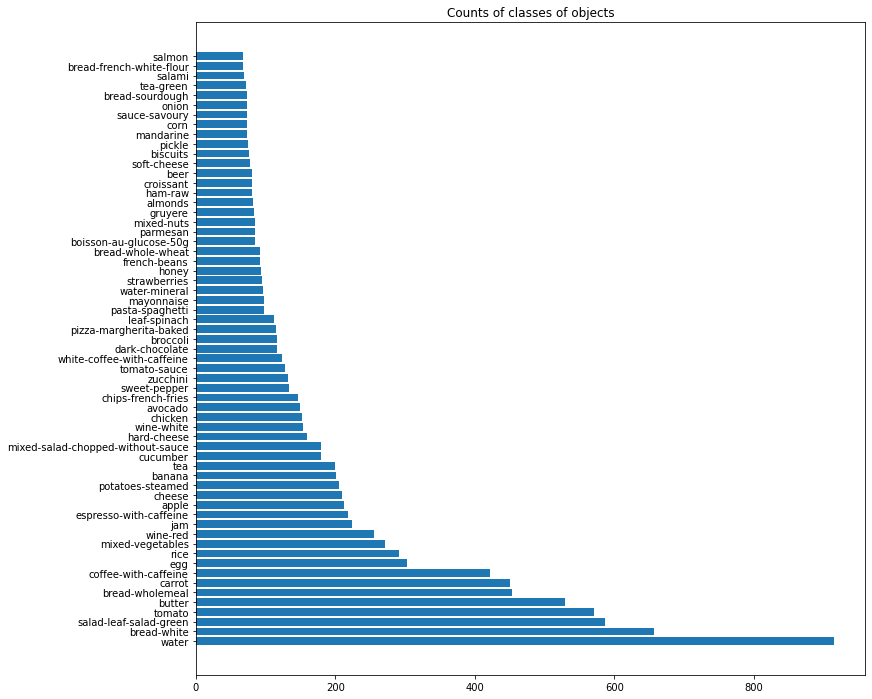

In [25]:
for image_info in dataset.image_info:
    ann = image_info["annotations"]
    
    for i in ann:
        class_counts[i["category_id"]] += 1
    
class_mapping = {i["id"]: i["name"] for i in dataset.class_info}

class_counts = pd.DataFrame(class_counts.most_common(), columns=["class", "count"])
class_counts["class"] = class_counts["class"].apply(lambda x: class_mapping[x])
plt.figure(figsize=(12, 12))
plt.barh(class_counts['class'], class_counts['count'])
plt.title('Counts of classes of objects');

In [26]:
print(f'We have {class_counts.shape[0]} classes!')

We have 61 classes!


crowdai_food_challenge
image 2241 crowai-food-challenge::2241
mask                     shape: (512, 512, 1)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:   46.00000  max:   46.00000  uint32
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
bbox                     shape: (1, 4)                min:   53.00000  max:  394.00000  int32


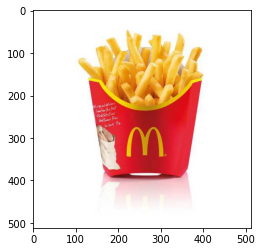

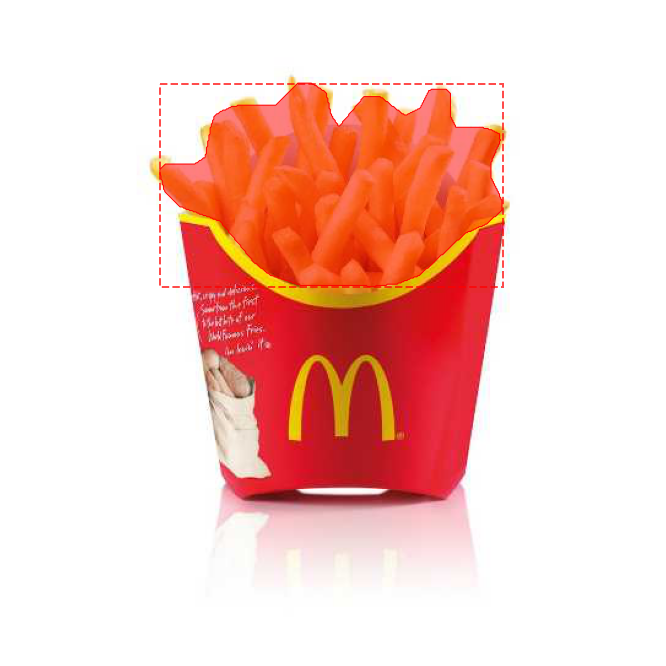

In [27]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
plt.imshow(image)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

print("image", image_id, dataset.image_reference(image_id))
log("mask", mask)
log("class_ids", class_ids)
log("image", image)
log("bbox", bbox)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, figsize=(12, 12))

In [28]:
dataset.image_info[0]

{'id': 65561,
 'source': 'crowdai_food_challenge',
 'path': '../train/images/065561.jpg',
 'width': 464,
 'height': 464,
 'annotations': [{'id': 102450,
   'image_id': 65561,
   'category_id': 2578,
   'segmentation': [[235.0,
     337.5,
     190.0,
     333.5,
     180.5,
     328.0,
     174.5,
     315.0,
     157.5,
     231.0,
     148.5,
     158.0,
     138.5,
     112.0,
     138.5,
     79.0,
     145.5,
     60.00000000000001,
     151.0,
     57.5,
     180.0,
     57.5,
     207.0,
     62.50000000000001,
     245.00000000000003,
     55.5,
     280.0,
     57.5,
     292.5,
     67.0,
     308.5,
     91.0,
     311.5,
     110.0,
     310.5,
     137.0,
     303.5,
     182.0,
     297.5,
     261.0,
     288.5,
     306.0,
     283.5,
     318.0,
     271.0,
     331.5,
     261.0,
     335.5]],
   'area': 40035.0,
   'bbox': [57.5, 138.5, 280.0, 173.0],
   'iscrowd': 0}]}

In [29]:
class_images = defaultdict(list)

for ind, image_info in enumerate(dataset.image_info):
    ann = image_info["annotations"]
    
    for i in ann:
        class_images[i['category_id']].append(ind)

crowdai_food_challenge


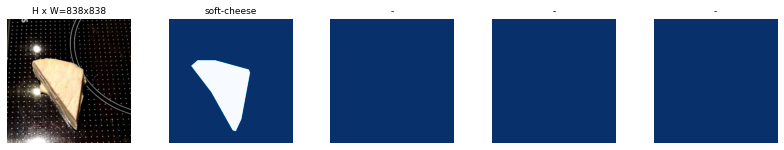

crowdai_food_challenge


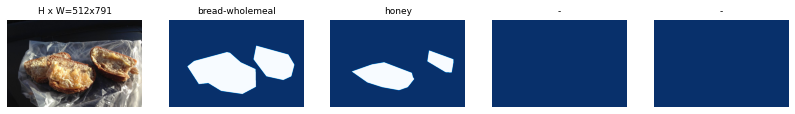

crowdai_food_challenge


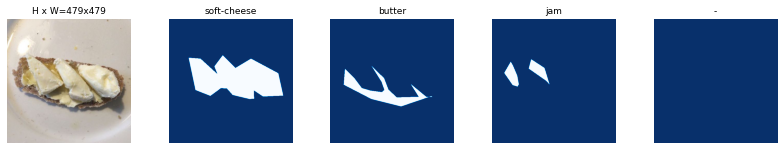

crowdai_food_challenge


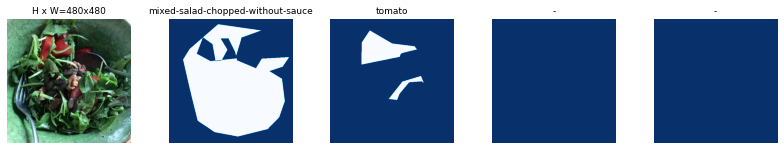

crowdai_food_challenge


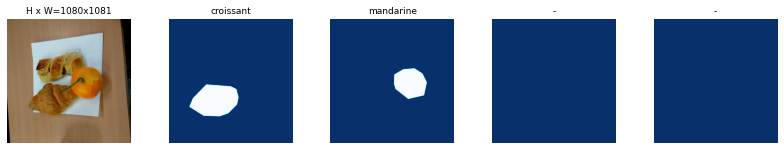

crowdai_food_challenge


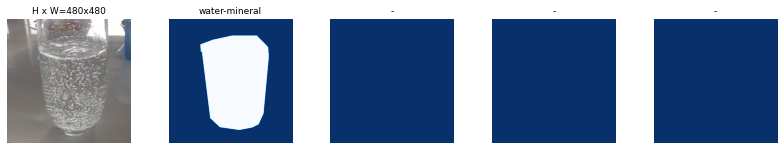

crowdai_food_challenge


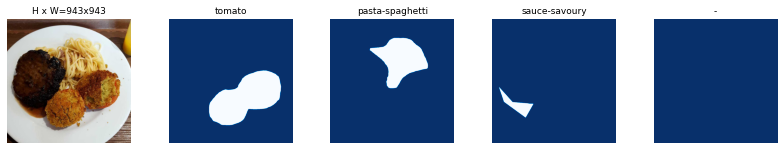

crowdai_food_challenge


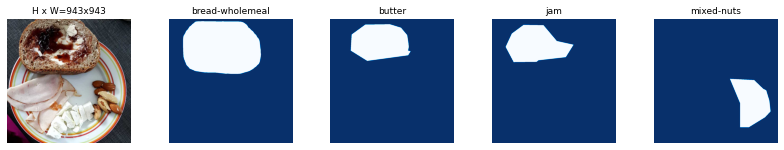

crowdai_food_challenge


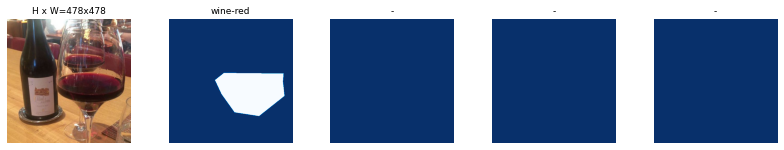

crowdai_food_challenge


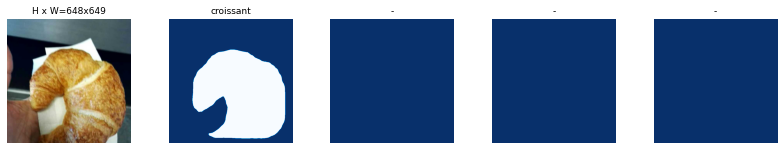

In [30]:
image_ids = np.random.choice(dataset.image_ids, 4)

for class_id in np.random.choice(list(class_images.keys()), 10):
    image_id = np.random.choice(class_images[class_id], 1)[0]
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bbox

crowdai_food_challenge


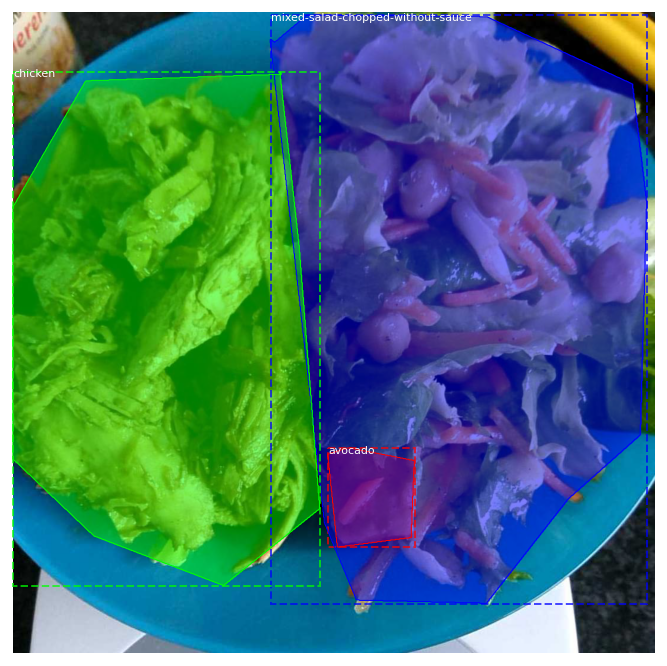

crowdai_food_challenge


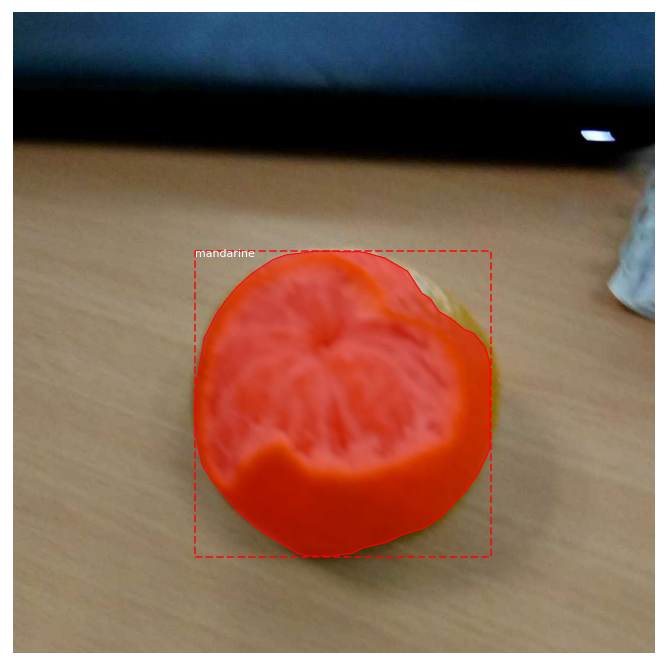

crowdai_food_challenge


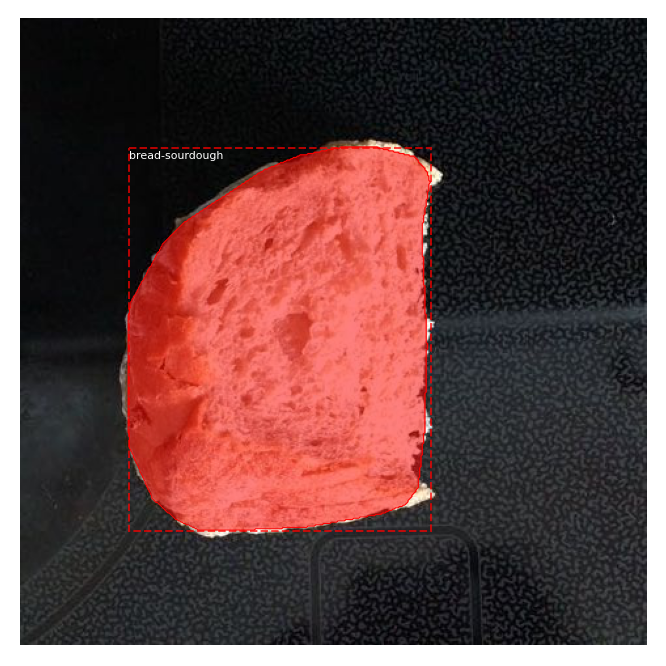

crowdai_food_challenge


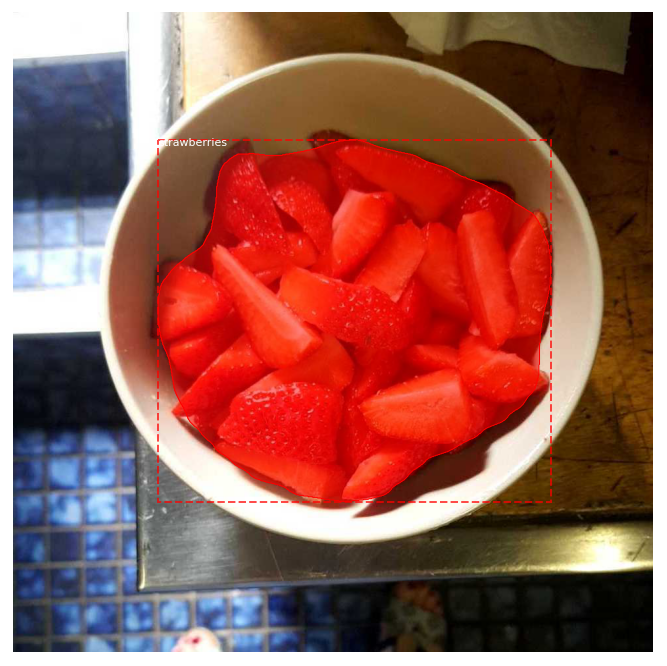

crowdai_food_challenge


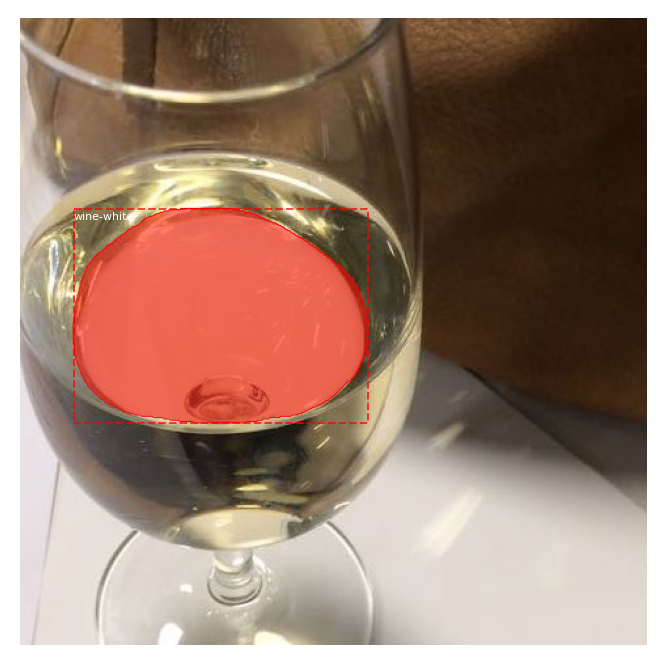

crowdai_food_challenge


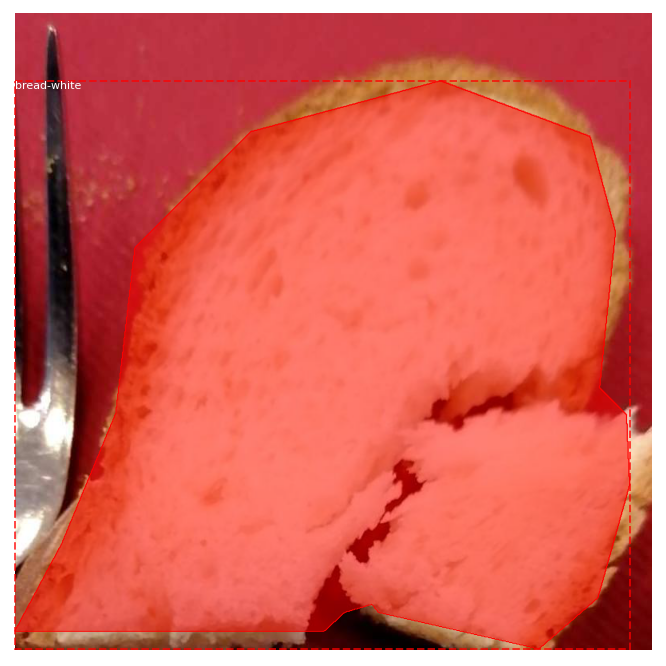

crowdai_food_challenge


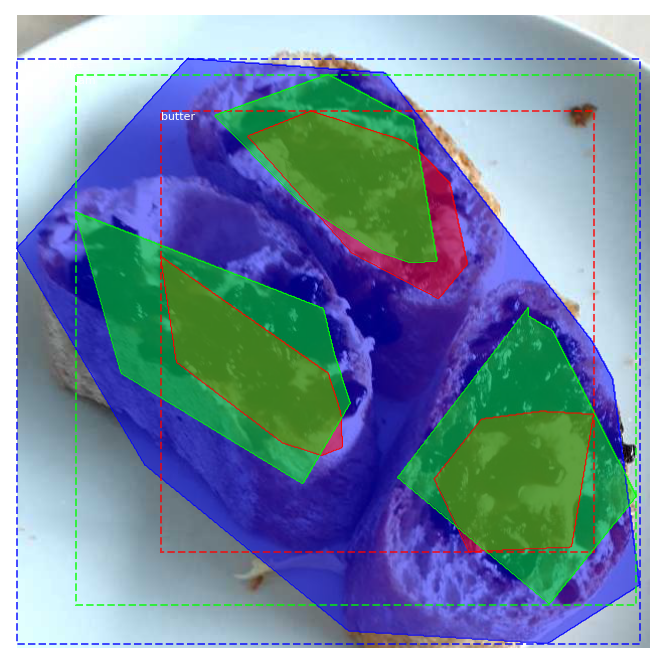

crowdai_food_challenge


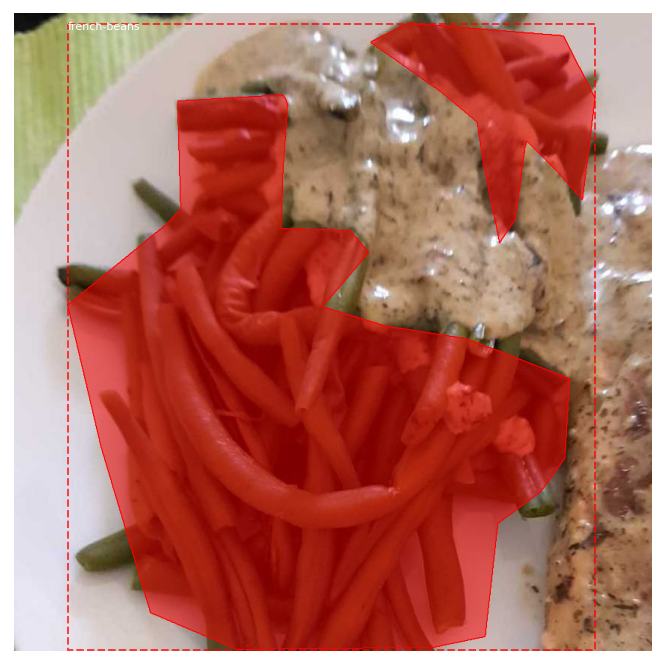

crowdai_food_challenge


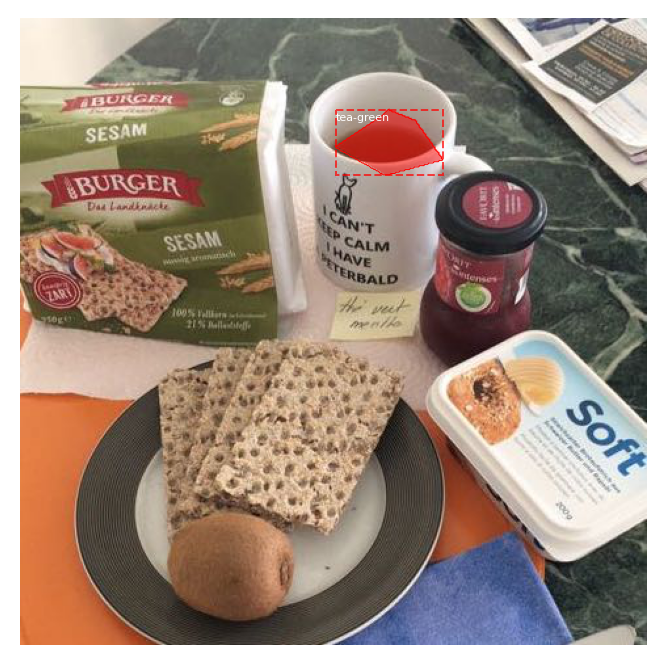

crowdai_food_challenge


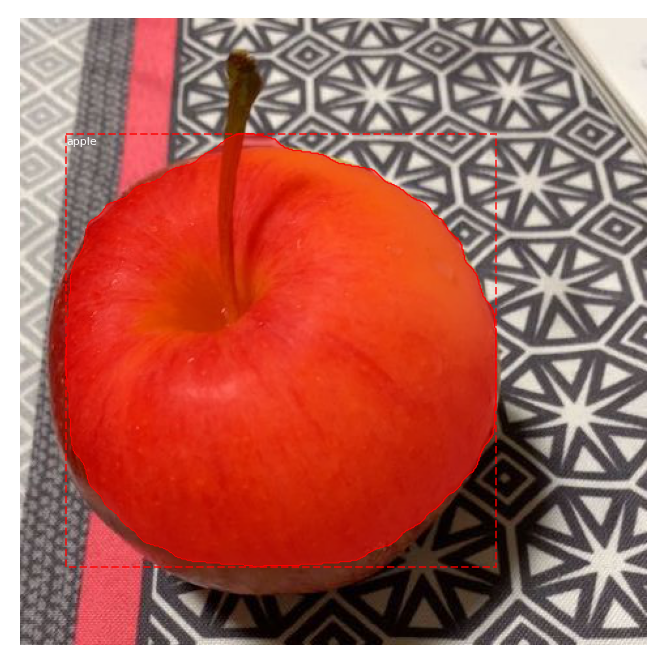

In [31]:
for idx, class_id in enumerate(np.random.choice(list(class_images.keys()), 10)):
    image_id = np.random.choice(list(class_images[class_id]), 1)[0]
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, figsize=(12, 12))

## Anchors

In [46]:
backbone_shape = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                         config.RPN_ANCHOR_RATIOS,
                                         backbone_shape,
                                         config.BACKBONE_STRIDES,
                                         config.RPN_ANCHOR_STRIDE)

In [47]:
num_levels = len(backbone_shape)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)

In [48]:
print("levels", num_levels)
print("scales", config.RPN_ANCHOR_SCALES)
print("ratio", config.RPN_ANCHOR_RATIOS)
print("anchors per cell", anchors_per_cell)
print("number anchors", anchors.shape[0])

levels 5
scales (32, 64, 128, 256, 512)
ratio [0.5, 1, 2]
anchors per cell 3
number anchors 16368


In [49]:
anchors_per_level = []

for l in range(num_levels):
    num_cells = backbone_shape[l][0] * backbone_shape[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    
    print("Anchors per level ", l, anchors_per_level[l])

Anchors per level  0 12288
Anchors per level  1 3072
Anchors per level  2 768
Anchors per level  3 192
Anchors per level  4 48


crowdai_food_challenge
Level 0. Anchors  12288 Feature map shape: [64 64]
Level 1. Anchors   3072 Feature map shape: [32 32]
Level 2. Anchors    768 Feature map shape: [16 16]
Level 3. Anchors    192 Feature map shape: [8 8]
Level 4. Anchors     48 Feature map shape: [4 4]


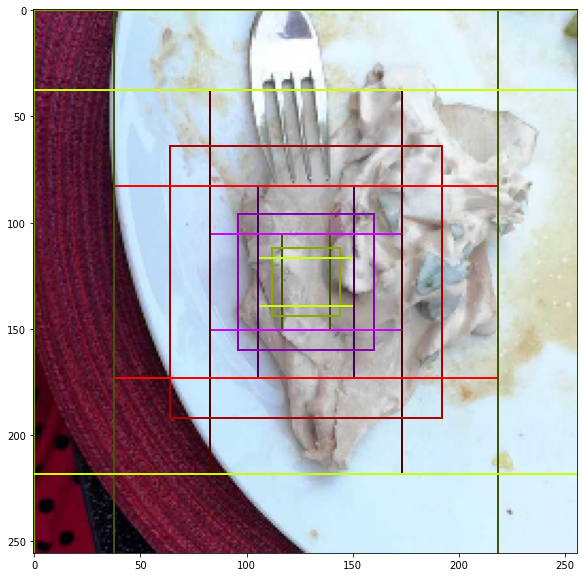

In [50]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)

levels = len(backbone_shape)

for level in range(levels):
    colors = visualize.random_colors(levels)
    level_start = sum(anchors_per_level[:level])
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors {:6} Feature map shape: {}".format(level, level_anchors.shape[0], backbone_shape[level]))
    
    center_cell = backbone_shape[level] // 2
    center_cell_index = (center_cell[0] * backbone_shape[level][1] + center_cell[1])
    
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shape[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)
    
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

## ROI

In [51]:
# random_rois = 2000
# dataset.class_ids.astype("int")

# g = modellib.data_generator(
#         dataset, config, shuffle=True, random_rois=random_rois, 
#         batch_size=4,
#         detection_targets=True
#     )

# if random_rois:
#     [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
#     [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
# else:
#     [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
# image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
# mrcnn_class_ids = mrcnn_class_ids[:,:,0]

# b = 0

# sample_image = modellib.unmold_image(normalized_images[b], config)

# # Compute anchor shifts.
# indices = np.where(rpn_match[b] == 1)[0]
# refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)

# # Get list of positive anchors
# positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
# negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
# neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]

# # ROI breakdown by class
# for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
#     if n:
#         print("{:23}: {}".format(c[:20], n))

# # Show positive anchors
# visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
#                      refined_boxes=refined_anchors)

In [52]:
# if random_rois:
#     # Class aware bboxes
#     bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

#     # Refined ROIs
#     refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

#     # Class aware masks
#     mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

#     visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
#     # Any repeated ROIs?
#     rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
#     _, idx = np.unique(rows, return_index=True)
    
#     print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

## Modeling with MaskRCNN

In [53]:
!mkdir pretrained

mkdir: pretrained: File exists


In [54]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [55]:
PRETRAINED_MODEL_PATH = os.path.join("pretrained", "mask_rcnn_coco.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")

if not os.path.exists(PRETRAINED_MODEL_PATH):
    utils.download_trained_weights(PRETRAINED_MODEL_PATH)

In [56]:
import keras.backend as K

In [57]:
if K.backend() == "tensorflow":
    K.common.image_dim_ordering()

In [159]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_DIRECTORY)
model_path = PRETRAINED_MODEL_PATH
model.load_weights(model_path, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"
])

In [160]:
dataset_train = FoodChallengeDataset()

In [161]:
dataset_train.load_dataset(DATA_TRAIN_DIR, load_small=False)

Annotation path ../train/annotations.json
Image Dir ../train/images
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [162]:
dataset_train.prepare()

In [163]:
dataset_val = FoodChallengeDataset()
val_coco = dataset_val.load_dataset(dataset_dir=DATA_VAL_DIR, load_small=False, return_coco=True)
dataset_val.prepare()

Annotation path ../val/annotations.json
Image Dir ../val/images
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [164]:
class_names = dataset_train.class_names
assert len(class_names)==62, "Please check DatasetConfig"

In [165]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

file_path = "logs/best_weight.hdf5"

custom_callback = ModelCheckpoint(filepath=file_path, mode="min", verbose=1, monitor="val_acc", save_best_only=True)

In [166]:
config.LEARNING_RATE

0.001

In [167]:
def learning_rate_schedule(epoch):
    initial_learning_rate = config.LEARNING_RATE
    factor = 0.25
    drop_every = 10
    alpha = initial_learning_rate * (factor ** np.floor((1 + epoch)/drop_every))

In [170]:
print("Training network")

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=45,
            layers='heads', custom_callbacks=[custom_callback, LearningRateScheduler(learning_rate_schedule)],
            augmentation=DATA_AUGMENTATION_SEQUENCE
           )

In [169]:
!rm logs/crowai-food-challenge20200427T0506/mask_rcnn_crowai-food-challenge_0039.h5

In [ ]:
model.epoch = 45

##  Prediction

In [68]:
class InferenceConfig(FoodChallengeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 62
    IMAGE_MAX_DIM = 256
    IMAGE_MIN_DIM = 256
    NAME = "Food"
    DETECTION_MIN_CONFIDENCE = 0

In [69]:
inference_config = InferenceConfig()

In [70]:
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                74
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [71]:
model_weight_path = "../mask_rcnn_crowai-food-challenge_0032.h5"

In [72]:
model = modellib.MaskRCNN(model_dir=ROOT_DIR,
                          config=inference_config,
                          mode='inference')



Instructions for updating:
Use `tf.cast` instead.


In [73]:
model.load_weights(model_weight_path, by_name=True)

crowdai_food_challenge


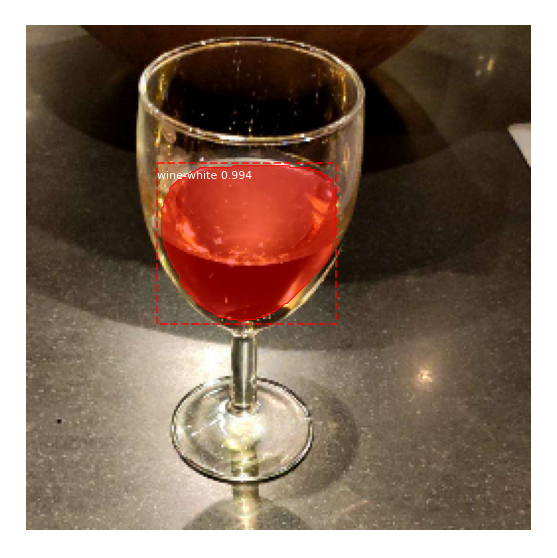

crowdai_food_challenge


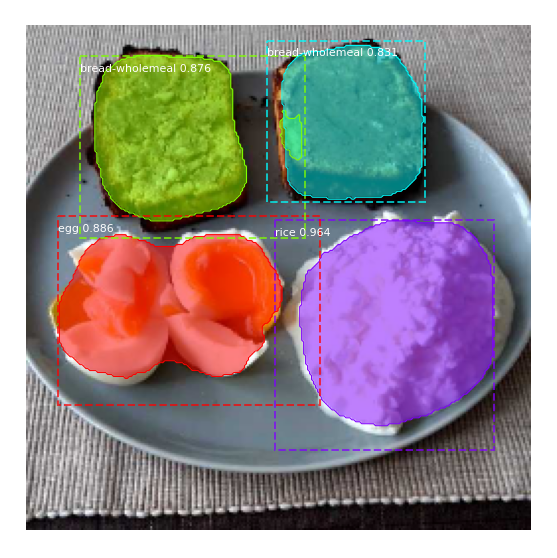

crowdai_food_challenge


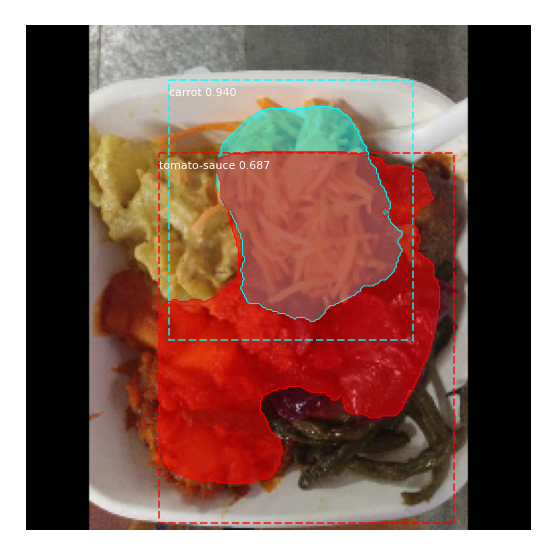

crowdai_food_challenge


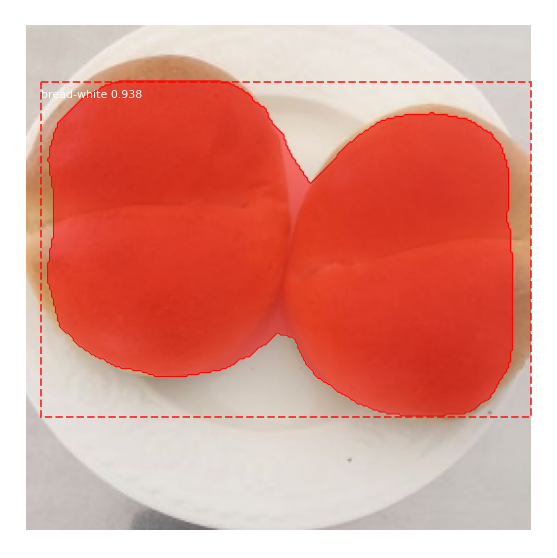

In [121]:
# fig = plt.figure(figsize=(1, 11))

for i in range(4):
    image_id = np.random.choice(dataset_val.image_ids, 1)[0]
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
#     print(original_image.shape)
#     plt.subplot(6, 2, 2*i + 1)
#     visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset.class_names, ax=fig.axes[-1])
    
    
#     plt.subplot(6, 2, 2*i + 2)
    r = model.detect([original_image])
    r = r[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], figsize=(10, 10))

In [117]:
# image = dataset_val.load_image(image_id)